In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skopt
import dill
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [2]:
##Takes in working_ion and returns battery data targets and labels for that specfic working ion##
def get_working_ion_batt_data(batt_data_target, batt_data_labels, element):
        
    target = pd.DataFrame(columns = batt_data_target.columns)
    labels = pd.Series(name = 'average_voltage')
    for index, row in batt_data_target.iterrows():
        if row['working_ion_' + str(element)] == 1:
            target = target.append(row, ignore_index = True)
            labels = labels.append(pd.Series(batt_data_labels[index]), ignore_index = True)
    
    return target, labels

In [3]:
##Create DNN model##
def get_model(h_units, h_layers, weight_decay, dropout_rate, input_shape):
    
    ##Make model##
    for i in range(h_layers):
        if i == 0:
            model = Sequential()
            model.add(Dense(h_units, kernel_regularizer = tf.keras.regularizers.l2(l = weight_decay), use_bias = False, input_shape = input_shape))
            model.add(BatchNormalization())
            model.add(ReLU())
            model.add(Dropout(dropout_rate))
        elif i == (h_layers-1):
            model.add(Dense(1))
        else:
            model.add(Dense(h_units, kernel_regularizer = tf.keras.regularizers.l2(l = weight_decay), use_bias = False))
            model.add(BatchNormalization())
            model.add(ReLU())
            model.add(Dropout(dropout_rate))

    return model

In [4]:
##Compile DNN model##
def compile_model(model, learning_rate): 
    
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    losses = tf.keras.losses.MeanAbsoluteError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer = opt, loss = losses, metrics = [mae])

In [5]:
##Checkpoint to obtain weights with best val_mean_absolute_error##
def save_best_val_weights(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, fold):
    
    checkpoint_path = f"model_best/val_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
    checkpoint = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_mean_absolute_error',
                                 save_weights_only = False, save_best_only = True)
    
    return checkpoint

In [6]:
##Checkpoint to obtain weights with best val_mean_absolute_error##
def save_best_train_weights(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, fold):
    
    checkpoint_path = f"model_best/train_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
    checkpoint = ModelCheckpoint(filepath = checkpoint_path, monitor = 'mean_absolute_error',
                                 save_weights_only = False, save_best_only = True)
    
    return checkpoint

In [17]:
##Function that returns accuracy for hyperparameter optimization##
@use_named_args(dimensions = dimensions)
def fitness(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size):
    
    ##Print the hyper-parameters##
    print('h_layers:', h_layers)
    print('h_units:', h_units)
    print('weight_decay: {0:.1e}'.format(weight_decay))
    print('dropout_rate: {0:.1e}'.format(dropout_rate))
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('batch_size', batch_size)
    print()
    
    ##Use KFold to train model##
    kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
    fold = 0
    mae = []
    
    ##Iterate through folds##
    for train_index, test_index in kf.split(batt_data_target):
        
        ##Create train and test data##
        x_train = batt_data_target.iloc[train_index, :]
        y_train = batt_data_labels.iloc[train_index]
        x_test = batt_data_target.iloc[test_index, :]
        y_test = batt_data_labels.iloc[test_index]
        
        ##Get model##
        model = get_model(h_units, h_layers, weight_decay, dropout_rate, [x_train.shape[1], ])
    
        ##Compile model##
        compile_model(model, learning_rate)
    
        ##Train model##
        history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = 100, callbacks = None, 
                  validation_split = 0.1, verbose = 0)
    
        ##Get the MAE on the validation-set after the last training-epoch##
        fold_mae = history.history['val_mean_absolute_error'][-1]
        mae.append(fold_mae)

        ##Delete the Keras model with these hyper-parameters from memory##
        del model

        ##Clear the Keras session, otherwise it will keep adding new models to the same TensorFlow graph each time we create##
        ##a model with a different set of hyper-parameters##
        tf.keras.backend.clear_session()
    
    mae_sum = sum(mae)
    mae_avg = mae_sum / 10
    print(f"mae_sum : {mae_sum}")
    print(f"mae_avg : {mae_avg}")
    print()
    
    return mae_sum

In [8]:
##Train model and print results##
def train_model(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size):
    
    ##Use KFold to train model##
    kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
    fold = 0
    mae = []
    
    ##Iterate through folds##
    for train_index, test_index in kf.split(batt_data_target):
        
        ##Create train and test data##
        x_train = batt_data_target.iloc[train_index, :]
        y_train = batt_data_labels.iloc[train_index]
        x_test = batt_data_target.iloc[test_index, :]
        y_test = batt_data_labels.iloc[test_index]
        
        ##Get model##
        model = get_model(h_units, h_layers, weight_decay, dropout_rate, [x_train.shape[1], ])
        model.summary()

        ##Compile model##
        compile_model(model, learning_rate)

        ##Create callbacks##
        fold += 1
        best_val_weights = save_best_val_weights(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, fold)
        best_train_weights = save_best_train_weights(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, fold)
        
        ##Fit model##
        history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = 1000, 
                  callbacks = [best_val_weights, best_train_weights], validation_split = 0.1, verbose = 0)

        ##Plot training and validation metrics##
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Loss vs. Epochs for Fold {fold}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper right')
        plt.show() 
        plt.savefig(f'Loss vs. Epochs for Fold {fold}.png')

        plt.plot(history.history['mean_absolute_error'])
        plt.plot(history.history['val_mean_absolute_error'])
        plt.title(f'Mean Absolute Error vs. Epochs for Fold {fold}')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'], loc='upper right')
        plt.show()
        plt.savefig(f'Mean Absolute Error vs. Epochs for Fold {fold}.png')

        ##Evaluate on test set and plot performance metrics##
        test_loss, test_mae = model.evaluate(x = x_test, y = y_test)
        print(f'Mean Absolute Error: {test_mae}')
        mae.append(test_mae)
        
        ##Delete the Keras model with these hyper-parameters from memory##
        del model

        ##Clear the Keras session, otherwise it will keep adding new models to the same TensorFlow graph each time we create##
        ##a model with a different set of hyper-parameters##
        tf.keras.backend.clear_session()
    
    return mae

In [9]:
##Evalute the model from get_best_weights## 
def evaluate_best_model(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, model_type, test_data):
    
    ##Use KFold to train model##
    kf = KFold(n_splits = 10, shuffle = True, random_state = 42)
    fold = 0
    mae = []
    
    ##Evaluate on testset and plot performance metrics##
    for train_index, test_index in kf.split(batt_data_target):
        
        ##Create train and test data##
        x_train = batt_data_target.iloc[train_index, :]
        y_train = batt_data_labels.iloc[train_index]
        x_test = batt_data_target.iloc[test_index, :]
        y_test = batt_data_labels.iloc[test_index]
        fold += 1
        
        ##Load saved models##
        if model_type == 'val':
            checkpoint_path = f"model_best/val_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)
        elif model_type == 'train':
            checkpoint_path = f"model_best/train_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)
            
        ##Evaluate model##
        if test_data == 'all':
            test_loss, test_mae = model.evaluate(x = x_test, y = y_test)
            print(f'Mean Absolute Error for all: {test_mae}')
            mae.append(test_mae)
        elif test_data == 'Al':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Al, y = batt_data_labels_Al) 
            print(f'Mean Absolute Error for Al from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Ca':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Ca, y = batt_data_labels_Ca)
            print(f'Mean Absolute Error for Ca from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Cs':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Cs, y = batt_data_labels_Cs)
            print(f'Mean Absolute Error for Cs from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'K':
            test_loss, test_mae = model.evaluate(x = batt_data_target_K, y = batt_data_labels_K)
            print(f'Mean Absolute Error for K from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Li':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Li, y = batt_data_labels_Li)
            print(f'Mean Absolute Error for Li from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Mg':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Mg, y = batt_data_labels_Mg)
            print(f'Mean Absolute Error for Mg from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Na':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Na, y = batt_data_labels_Na)
            print(f'Mean Absolute Error for Na from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Rb':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Rb, y = batt_data_labels_Rb)
            print(f'Mean Absolute Error for Rb from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Y':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Y, y = batt_data_labels_Y)
            print(f'Mean Absolute Error for Y from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'Zn':
            test_loss, test_mae = model.evaluate(x = batt_data_target_Zn, y = batt_data_labels_Zn)
            print(f'Mean Absolute Error for Zn from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        elif test_data == 'expt':
            test_loss, test_mae = model.evaluate(x = expt_electrodes_data_target, y = expt_electrodes_data_labels)
            print(f'Mean Absolute Error for experimental electrodes from Fold {fold}: {test_mae}')
            mae.append(test_mae)
            #break
        
        ##Delete the Keras model with these hyper-parameters from memory##
        del model

        ##Clear the Keras session, otherwise it will keep adding new models to the same TensorFlow graph each time we create##
        ##a model with a different set of hyper-parameters##
        tf.keras.backend.clear_session()
        
    return mae

In [37]:
##Obtain preprocessed experimental electrode data##
def get_expt_electrodes_data():
    
    ##Import battery data##
    batt_data = pd.read_csv('battery_dataset.csv')
    expt_electrodes_data = pd.read_csv('experimental_electrodes_data.csv')
    
    ##Remove useless features and combine 2 datasets##
    batt_data = batt_data.drop(columns = ['Unnamed: 0', 'nsteps', 'numsites', 'spacegroup_hall_number', 'capacity_grav', 'capacity_vol', 'energy_grav', 
                                          'energy_vol', 'fracA_charge', 'fracA_discharge', 'stability_charge', 'stability_discharge'], axis = 0)
    expt_electrodes_data = expt_electrodes_data.drop(columns = ['Unnamed: 0'])
    batt_data = pd.concat([batt_data, expt_electrodes_data], axis = 0)
    
    ##Replace catergorical data (type, working_ion) in one hot style##
    batt_data = pd.get_dummies(batt_data, columns = ['type'], prefix = ['type'])
    batt_data = pd.get_dummies(batt_data, columns = ['working_ion'], prefix = ['working_ion'])
    
    ##Obtain target##
    batt_data_target = batt_data.drop(columns = ['average_voltage'], axis = 0)
    batt_data_labels = batt_data.loc[:, 'average_voltage']
    
    ##Standardize columns that are not in the catergorical columns##
    categorical_columns = batt_data.iloc[:, -11:].columns
    #print(categorical_columns)
    for column in batt_data_target.columns:
        if column in categorical_columns:
            continue
        else:
            scale = StandardScaler().fit(batt_data_target[[column]])
            batt_data_target[[column]] = scale.transform(batt_data_target[[column]])
    
    ##Obtain expt_electrode_data_target##
    expt_electrode_data_target = batt_data_target.iloc[-14:]
    expt_electrode_data_labels = batt_data_labels.iloc[-14:]
    #print(expt_electrode_data_target)
    
    return expt_electrode_data_target, expt_electrode_data_labels

In [11]:
##Give predictions for experimental_electrodes for model saved from all folds##
def get_predictions(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, model_type):
    
    ##Iterate over folds to predict data##
    for fold in range(1, 11, 1):
        
        ##Load saved models##
        if model_type == 'val':
            checkpoint_path = f"model_best/val_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)
        elif model_type == 'train':
            checkpoint_path = f"model_best/train_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)
        
        ##Get predictions##
        predictions = model.predict(expt_electrodes_data_target)
        print(f"Predictions from Fold {fold}: {predictions}")
    
        ##Delete the Keras model with these hyper-parameters from memory##
        del model

        ##Clear the Keras session, otherwise it will keep adding new models to the same TensorFlow graph each time we create##
        ##a model with a different set of hyper-parameters##
        tf.keras.backend.clear_session()

In [10]:
##Print layer weights for saved models##
def get_weights(h_units, h_layers, weight_decay, dropout_rate, learning_rate, batch_size, model_type):
    
    ##Iterate over folds to predict data##
    for fold in range(1, 11, 1):
        
        ##Load saved models##
        if model_type == 'val':
            checkpoint_path = f"model_best/val_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)
        elif model_type == 'train':
            checkpoint_path = f"model_best/train_best/h_units_{h_units}_h_layers_{h_layers}_wd_{weight_decay}_dr_{dropout_rate}_lr_{learning_rate}_batch size_{batch_size}_fold_{fold}"
            model = load_model(checkpoint_path)

        ##Get weights from first dense layer, obtain the absolute sum of the weights for each input and identify features with##
        ##highest weights out of 114##
        for lay in model.layers:
            if lay.name == 'dense':
                dense_weights = lay.get_weights()
                print(f"Fold {fold} weights")
                print(dense_weights)
                print(np.shape(dense_weights))
                feature_weights_abs_sum = np.zeros(114) 
                for i in range(np.shape(dense_weights)[1]):
                    for j in range(np.shape(dense_weights)[2]):
                        feature_weights_abs_sum[i] += abs(dense_weights[0][i][j])
                ind = np.argpartition(feature_weights_abs_sum, -10)[-10:]
                ind = ind[np.argsort(feature_weights_abs_sum[ind])]
                print(ind)
                features = list(batt_data_target.columns)
                rank = 1
                for k in range(len(ind) - 1, -1, -1):
                    print(f"Number {rank} feature for Fold {fold}: {features[ind[k]]}")
                    rank += 1
        ##Delete the Keras model with these hyper-parameters from memory##
        del model

        ##Clear the Keras session, otherwise it will keep adding new models to the same TensorFlow graph each time we create##
        ##a model with a different set of hyper-parameters##
        tf.keras.backend.clear_session()

In [11]:
get_weights(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'train')

Fold 1 weights
[array([[-0.37723348, -0.48446164,  0.55865616, ...,  0.11067998,
        -0.01072234, -0.2068665 ],
       [-0.00128018, -0.41302243,  0.19640544, ..., -0.01336117,
        -0.02703892, -0.39569804],
       [ 0.3104492 , -0.2378855 , -0.21380262, ...,  0.41501334,
         0.16809405, -0.0667583 ],
       ...,
       [ 0.38050047, -0.46562195, -0.14434224, ...,  0.3647602 ,
         0.95874494, -0.1896388 ],
       [ 0.5457393 , -0.00753167, -0.3230571 , ..., -0.12035558,
        -0.1230178 , -0.28316697],
       [-0.25034136, -0.0422729 , -0.21802181, ..., -0.53968835,
        -1.1817626 , -0.6994425 ]], dtype=float32)]
(1, 114, 400)
[105   1   2   0 111 112 107 104 106 113]
Number 1 feature for Fold 1: working_ion_Zn
Number 2 feature for Fold 1: working_ion_Cs
Number 3 feature for Fold 1: working_ion_Al
Number 4 feature for Fold 1: working_ion_K
Number 5 feature for Fold 1: working_ion_Y
Number 6 feature for Fold 1: working_ion_Rb
Number 7 feature for Fold 1: min_frac

Fold 9 weights
[array([[-0.3294167 , -0.02142902, -0.37055078, ...,  0.16265036,
         0.18434976,  0.1517281 ],
       [ 0.08496371, -0.16380264, -0.83797646, ...,  0.2832302 ,
        -0.19887145,  0.50413287],
       [ 0.44287932, -0.20932505, -0.42591912, ..., -0.28631368,
        -0.135172  ,  0.14617644],
       ...,
       [-0.045586  , -0.2953811 , -0.08068483, ..., -0.12035742,
        -0.04485346, -0.22232017],
       [ 0.22452492,  0.1248361 , -0.15210116, ..., -0.57166874,
         0.24649559, -0.45824844],
       [-0.32268363, -0.72828645,  0.20121422, ...,  0.24184848,
        -0.4087777 , -0.30841383]], dtype=float32)]
(1, 114, 400)
[  1 110 111   2   0 112 104 107 113 106]
Number 1 feature for Fold 9: working_ion_Cs
Number 2 feature for Fold 9: working_ion_Zn
Number 3 feature for Fold 9: working_ion_K
Number 4 feature for Fold 9: working_ion_Al
Number 5 feature for Fold 9: working_ion_Y
Number 6 feature for Fold 9: min_frac
Number 7 feature for Fold 9: spacegroup_num

In [3]:
##Import battery data##
batt_data = pd.read_csv('battery_dataset.csv')
#print(batt_data)

##Remove useless features##
batt_data = batt_data.drop(columns = ['Unnamed: 0', 'nsteps', 'numsites', 'spacegroup_hall_number', 'capacity_grav', 'capacity_vol', 'energy_grav', 
                                      'energy_vol', 'fracA_charge', 'fracA_discharge', 'stability_charge', 'stability_discharge'], axis = 0)
#print(batt_data)

##Replace catergorical data (type, working_ion) in one hot style##
batt_data = pd.get_dummies(batt_data, columns = ['type'], prefix = ['type'])
batt_data = pd.get_dummies(batt_data, columns = ['working_ion'], prefix = ['working_ion'])
#print(batt_data)

##Obtain target and labels data##
batt_data_target = batt_data.drop(columns = ['average_voltage'], axis = 0)
batt_data_labels = batt_data.loc[:, 'average_voltage']
# print(batt_data_target)
# print(batt_data_labels)

##Standardize columns that are not in the catergorical columns##
categorical_columns = batt_data.iloc[:, -11:].columns
#print(categorical_columns)
for column in batt_data_target.columns:
    if column in categorical_columns:
        continue
    else:
        scale = StandardScaler().fit(batt_data_target[[column]])
        batt_data_target[[column]] = scale.transform(batt_data_target[[column]])
print(batt_data_target.columns)
#print(batt_data_labels)

##Get expt_electrode_data_target##
expt_electrodes_data_target, expt_electrodes_data_labels = get_expt_electrodes_data()
print(expt_electrodes_data_target.columns)

##Get data based on sorted based on working_ion##
working_ions = ['Al', 'Ca', 'Cs', 'K', 'Li', 'Mg', 'Na', 'Rb', 'Y', 'Zn']
for ion in working_ions:
    if ion == 'Al':
        batt_data_target_Al, batt_data_labels_Al = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Al.shape}")
    if ion == 'Ca':
        batt_data_target_Ca, batt_data_labels_Ca = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Ca.shape}")
    if ion == 'Cs':
        batt_data_target_Cs, batt_data_labels_Cs = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Cs.shape}")
    if ion == 'K':
        batt_data_target_K, batt_data_labels_K = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_K.shape}")
    if ion == 'Li':
        batt_data_target_Li, batt_data_labels_Li = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Li.shape}")
    if ion == 'Mg':
        batt_data_target_Mg, batt_data_labels_Mg = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Mg.shape}")
    if ion == 'Na':
        batt_data_target_Na, batt_data_labels_Na = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Na.shape}")
    if ion == 'Rb':
        batt_data_target_Rb, batt_data_labels_Rb = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Rb.shape}")
    if ion == 'Y':
        batt_data_target_Y, batt_data_labels_Y = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Y.shape}")
    if ion == 'Zn':
        batt_data_target_Zn, batt_data_labels_Zn = get_working_ion_batt_data(batt_data_target, batt_data_labels, ion)
        print(f"{ion}'s battery data target shape is {batt_data_target_Zn.shape}")

Index(['min_frac', 'max_frac', 'spacegroup_number', 'max_lp_norm_0',
       'max_lp_norm_2', 'max_lp_norm_3', 'max_lp_norm_5', 'max_lp_norm_7',
       'max_lp_norm_10', 'min_lp_norm_0',
       ...
       'working_ion_Al', 'working_ion_Ca', 'working_ion_Cs', 'working_ion_K',
       'working_ion_Li', 'working_ion_Mg', 'working_ion_Na', 'working_ion_Rb',
       'working_ion_Y', 'working_ion_Zn'],
      dtype='object', length=114)
Index(['min_frac', 'max_frac', 'spacegroup_number', 'max_lp_norm_0',
       'max_lp_norm_2', 'max_lp_norm_3', 'max_lp_norm_5', 'max_lp_norm_7',
       'max_lp_norm_10', 'min_lp_norm_0',
       ...
       'working_ion_Al', 'working_ion_Ca', 'working_ion_Cs', 'working_ion_K',
       'working_ion_Li', 'working_ion_Mg', 'working_ion_Na', 'working_ion_Rb',
       'working_ion_Y', 'working_ion_Zn'],
      dtype='object', length=114)


D:\anaconda3\envs\machine_learning_urops_battery\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


Al's battery data target shape is (149, 114)
Ca's battery data target shape is (484, 114)
Cs's battery data target shape is (39, 114)
K's battery data target shape is (125, 114)
Li's battery data target shape is (2291, 114)
Mg's battery data target shape is (393, 114)
Na's battery data target shape is (328, 114)
Rb's battery data target shape is (50, 114)
Y's battery data target shape is (157, 114)
Zn's battery data target shape is (385, 114)


In [18]:
##List dimensions for optimizing##
dim_learning_rate = Real(low = 1e-6, high = 1e-1, prior = 'log-uniform', name = 'learning_rate')
dim_h_layers = Integer(low = 2, high = 10, name = 'h_layers')
dim_h_units = Integer(low = 16, high = 512, name = 'h_units')
dim_weight_decay = Real(low = 1e-99, high = 1e-3, prior = 'log-uniform', name = 'weight_decay')
dim_dropout_rate = Real(low = 1e-99, high = 0.5, name = 'dropout_rate')
dim_batch_size = Integer(low = 16, high = 512, name = 'batch_size')
dimensions = [dim_h_units, dim_h_layers, dim_weight_decay, dim_dropout_rate, dim_learning_rate, dim_batch_size]

##Set up default_parameters##
default_parameters = [128, 5, 1e-98, 1e-98, 1e-3, 128]

In [19]:
##Optimize parameters##
search_result = gp_minimize(func = fitness, dimensions = dimensions, acq_func = 'EI', n_calls = 500, n_jobs = -1, x0 = default_parameters)

h_layers: 5
h_units: 128
weight_decay: 1.0e-98
dropout_rate: 1.0e-98
learning rate: 1.0e-03
batch_size 128

mae_sum : 4.117373764514923
mae_avg : 0.41173737645149233

h_layers: 9
h_units: 24
weight_decay: 7.3e-50
dropout_rate: 9.4e-02
learning rate: 1.5e-03
batch_size 471

mae_sum : 4.75530344247818
mae_avg : 0.475530344247818

h_layers: 7
h_units: 363
weight_decay: 1.6e-64
dropout_rate: 3.9e-01
learning rate: 2.9e-03
batch_size 219

mae_sum : 4.525120943784714
mae_avg : 0.4525120943784714

h_layers: 3
h_units: 387
weight_decay: 1.8e-30
dropout_rate: 3.1e-01
learning rate: 2.0e-05
batch_size 384

mae_sum : 7.8236618638038635
mae_avg : 0.7823661863803864

h_layers: 4
h_units: 76
weight_decay: 7.6e-97
dropout_rate: 6.5e-02
learning rate: 2.4e-03
batch_size 79

mae_sum : 4.565982848405838
mae_avg : 0.4565982848405838

h_layers: 8
h_units: 366
weight_decay: 3.8e-91
dropout_rate: 4.2e-02
learning rate: 2.7e-06
batch_size 510

mae_sum : 22.9926096200943
mae_avg : 2.2992609620094298

h_layers

mae_sum : 5.078940361738205
mae_avg : 0.5078940361738205

h_layers: 10
h_units: 244
weight_decay: 2.7e-13
dropout_rate: 4.9e-01
learning rate: 2.5e-04
batch_size 473

mae_sum : 14.26882779598236
mae_avg : 1.4268827795982362

h_layers: 6
h_units: 338
weight_decay: 2.2e-14
dropout_rate: 2.7e-02
learning rate: 3.6e-05
batch_size 42

mae_sum : 4.500153601169586
mae_avg : 0.45001536011695864

h_layers: 10
h_units: 340
weight_decay: 3.4e-77
dropout_rate: 4.9e-01
learning rate: 1.1e-06
batch_size 445

mae_sum : 20.981547117233276
mae_avg : 2.0981547117233275

h_layers: 2
h_units: 190
weight_decay: 4.5e-67
dropout_rate: 3.5e-02
learning rate: 1.0e-06
batch_size 110

mae_sum : 19.49716293811798
mae_avg : 1.949716293811798

h_layers: 6
h_units: 120
weight_decay: 3.2e-97
dropout_rate: 6.5e-02
learning rate: 2.2e-02
batch_size 490

mae_sum : 4.09964594244957
mae_avg : 0.40996459424495696

h_layers: 10
h_units: 69
weight_decay: 8.3e-12
dropout_rate: 5.0e-01
learning rate: 2.0e-03
batch_size 296

ma

h_layers: 10
h_units: 479
weight_decay: 7.2e-60
dropout_rate: 7.8e-02
learning rate: 3.9e-05
batch_size 494

mae_sum : 5.975518643856049
mae_avg : 0.5975518643856048

h_layers: 4
h_units: 27
weight_decay: 4.6e-74
dropout_rate: 4.3e-01
learning rate: 3.7e-04
batch_size 35

mae_sum : 5.369845986366272
mae_avg : 0.5369845986366272

h_layers: 9
h_units: 475
weight_decay: 7.4e-58
dropout_rate: 5.2e-02
learning rate: 1.4e-06
batch_size 37

mae_sum : 9.506068587303162
mae_avg : 0.9506068587303161

h_layers: 2
h_units: 505
weight_decay: 4.1e-63
dropout_rate: 4.9e-01
learning rate: 3.8e-02
batch_size 29

mae_sum : 6.065045416355133
mae_avg : 0.6065045416355133

h_layers: 4
h_units: 508
weight_decay: 7.5e-59
dropout_rate: 4.6e-01
learning rate: 5.3e-05
batch_size 505

mae_sum : 9.514094054698944
mae_avg : 0.9514094054698944

h_layers: 9
h_units: 36
weight_decay: 1.1e-21
dropout_rate: 8.2e-03
learning rate: 1.3e-02
batch_size 350

mae_sum : 4.685866296291351
mae_avg : 0.4685866296291351

h_layers

mae_sum : 4.3140281438827515
mae_avg : 0.43140281438827516

h_layers: 10
h_units: 43
weight_decay: 6.1e-44
dropout_rate: 4.0e-01
learning rate: 9.1e-02
batch_size 509

mae_sum : 9.50483924150467
mae_avg : 0.9504839241504669

h_layers: 10
h_units: 309
weight_decay: 2.8e-97
dropout_rate: 2.9e-01
learning rate: 1.6e-02
batch_size 228

mae_sum : 4.627873986959457
mae_avg : 0.46278739869594576

h_layers: 2
h_units: 285
weight_decay: 5.7e-22
dropout_rate: 5.0e-01
learning rate: 2.1e-03
batch_size 389

mae_sum : 4.587472528219223
mae_avg : 0.4587472528219223

h_layers: 4
h_units: 398
weight_decay: 2.4e-85
dropout_rate: 1.4e-02
learning rate: 1.6e-03
batch_size 305

mae_sum : 3.722920745611191
mae_avg : 0.37229207456111907

h_layers: 10
h_units: 508
weight_decay: 5.9e-75
dropout_rate: 2.5e-01
learning rate: 9.4e-06
batch_size 295

mae_sum : 9.238346993923187
mae_avg : 0.9238346993923188

h_layers: 2
h_units: 63
weight_decay: 3.9e-85
dropout_rate: 1.7e-02
learning rate: 8.2e-02
batch_size 498



mae_sum : 4.660890221595764
mae_avg : 0.4660890221595764

h_layers: 9
h_units: 481
weight_decay: 3.5e-56
dropout_rate: 3.4e-03
learning rate: 2.1e-02
batch_size 495

mae_sum : 4.820898324251175
mae_avg : 0.4820898324251175

h_layers: 2
h_units: 27
weight_decay: 7.4e-30
dropout_rate: 4.9e-01
learning rate: 4.2e-06
batch_size 34

mae_sum : 17.209624409675598
mae_avg : 1.72096244096756

h_layers: 2
h_units: 510
weight_decay: 4.7e-89
dropout_rate: 2.6e-01
learning rate: 2.7e-02
batch_size 187

mae_sum : 5.060251832008362
mae_avg : 0.5060251832008362

h_layers: 2
h_units: 94
weight_decay: 3.1e-81
dropout_rate: 2.7e-01
learning rate: 1.0e-02
batch_size 499

mae_sum : 4.646906316280365
mae_avg : 0.4646906316280365

h_layers: 10
h_units: 499
weight_decay: 3.1e-69
dropout_rate: 4.8e-01
learning rate: 4.0e-02
batch_size 458

mae_sum : 5.203485667705536
mae_avg : 0.5203485667705536

h_layers: 10
h_units: 510
weight_decay: 2.3e-17
dropout_rate: 2.1e-02
learning rate: 1.4e-05
batch_size 477

mae_su

mae_sum : 4.6672254502773285
mae_avg : 0.46672254502773286

h_layers: 10
h_units: 56
weight_decay: 1.1e-45
dropout_rate: 2.2e-01
learning rate: 6.2e-03
batch_size 470

mae_sum : 4.40646755695343
mae_avg : 0.440646755695343

h_layers: 10
h_units: 279
weight_decay: 1.5e-93
dropout_rate: 3.1e-03
learning rate: 1.1e-02
batch_size 419

mae_sum : 4.4584861397743225
mae_avg : 0.44584861397743225

h_layers: 2
h_units: 261
weight_decay: 2.3e-44
dropout_rate: 2.2e-01
learning rate: 7.0e-05
batch_size 312

mae_sum : 5.282287567853928
mae_avg : 0.5282287567853927

h_layers: 10
h_units: 502
weight_decay: 5.6e-72
dropout_rate: 1.7e-02
learning rate: 6.4e-06
batch_size 18

mae_sum : 7.387862384319305
mae_avg : 0.7387862384319306

h_layers: 10
h_units: 139
weight_decay: 3.9e-87
dropout_rate: 2.3e-01
learning rate: 5.5e-02
batch_size 318

mae_sum : 5.801720291376114
mae_avg : 0.5801720291376113

h_layers: 10
h_units: 56
weight_decay: 7.1e-36
dropout_rate: 6.7e-02
learning rate: 8.3e-02
batch_size 24

m

mae_sum : 26.07148027420044
mae_avg : 2.607148027420044

h_layers: 2
h_units: 486
weight_decay: 8.2e-04
dropout_rate: 9.3e-03
learning rate: 1.5e-04
batch_size 183

mae_sum : 4.636232703924179
mae_avg : 0.4636232703924179

h_layers: 10
h_units: 46
weight_decay: 1.3e-56
dropout_rate: 4.7e-01
learning rate: 4.4e-05
batch_size 505

mae_sum : 15.14098346233368
mae_avg : 1.514098346233368

h_layers: 2
h_units: 16
weight_decay: 1.0e-85
dropout_rate: 4.6e-01
learning rate: 1.1e-06
batch_size 336

mae_sum : 22.522111654281616
mae_avg : 2.252211165428162

h_layers: 10
h_units: 236
weight_decay: 9.0e-56
dropout_rate: 2.5e-01
learning rate: 5.0e-02
batch_size 110

mae_sum : 5.383204281330109
mae_avg : 0.5383204281330108

h_layers: 2
h_units: 291
weight_decay: 4.1e-21
dropout_rate: 5.0e-01
learning rate: 5.7e-04
batch_size 507

mae_sum : 5.096626341342926
mae_avg : 0.5096626341342926

h_layers: 5
h_units: 506
weight_decay: 4.5e-05
dropout_rate: 4.0e-01
learning rate: 1.2e-02
batch_size 30

mae_sum

mae_sum : 4.516203701496124
mae_avg : 0.4516203701496124

h_layers: 7
h_units: 501
weight_decay: 5.8e-97
dropout_rate: 2.2e-03
learning rate: 2.1e-03
batch_size 399

mae_sum : 4.498096317052841
mae_avg : 0.4498096317052841

h_layers: 6
h_units: 38
weight_decay: 1.4e-62
dropout_rate: 4.9e-01
learning rate: 9.0e-06
batch_size 20

mae_sum : 10.680966436862946
mae_avg : 1.0680966436862946

h_layers: 5
h_units: 175
weight_decay: 1.2e-08
dropout_rate: 4.9e-01
learning rate: 2.5e-02
batch_size 511

mae_sum : 4.300609678030014
mae_avg : 0.4300609678030014

h_layers: 7
h_units: 505
weight_decay: 2.8e-63
dropout_rate: 1.9e-02
learning rate: 4.7e-05
batch_size 138

mae_sum : 4.233198434114456
mae_avg : 0.42331984341144563

h_layers: 4
h_units: 498
weight_decay: 8.0e-93
dropout_rate: 1.1e-02
learning rate: 7.6e-04
batch_size 48

mae_sum : 4.023147523403168
mae_avg : 0.4023147523403168

h_layers: 5
h_units: 149
weight_decay: 4.3e-71
dropout_rate: 2.9e-01
learning rate: 9.7e-02
batch_size 217

mae_s

mae_sum : 4.241356641054153
mae_avg : 0.42413566410541537

h_layers: 5
h_units: 156
weight_decay: 5.1e-74
dropout_rate: 4.5e-01
learning rate: 5.9e-05
batch_size 306

mae_sum : 7.616069555282593
mae_avg : 0.7616069555282593

h_layers: 4
h_units: 369
weight_decay: 5.5e-95
dropout_rate: 4.9e-01
learning rate: 8.1e-02
batch_size 25

mae_sum : 6.960339963436127
mae_avg : 0.6960339963436126

h_layers: 6
h_units: 323
weight_decay: 3.6e-88
dropout_rate: 4.9e-01
learning rate: 2.0e-03
batch_size 24

mae_sum : 5.122002720832825
mae_avg : 0.5122002720832824

h_layers: 5
h_units: 506
weight_decay: 1.1e-83
dropout_rate: 8.1e-03
learning rate: 2.4e-05
batch_size 84

mae_sum : 4.415848672389984
mae_avg : 0.4415848672389984

h_layers: 6
h_units: 18
weight_decay: 3.8e-56
dropout_rate: 1.3e-02
learning rate: 1.3e-02
batch_size 353

mae_sum : 4.786780476570129
mae_avg : 0.47867804765701294

h_layers: 7
h_units: 511
weight_decay: 6.2e-77
dropout_rate: 2.0e-01
learning rate: 2.6e-02
batch_size 101

mae_su

mae_sum : 6.202144682407379
mae_avg : 0.6202144682407379

h_layers: 10
h_units: 486
weight_decay: 1.1e-99
dropout_rate: 2.8e-01
learning rate: 8.5e-02
batch_size 340

mae_sum : 5.643252849578857
mae_avg : 0.5643252849578857

h_layers: 4
h_units: 461
weight_decay: 5.2e-65
dropout_rate: 5.0e-01
learning rate: 1.1e-03
batch_size 512

mae_sum : 4.675515919923782
mae_avg : 0.4675515919923782

h_layers: 6
h_units: 243
weight_decay: 1.6e-68
dropout_rate: 4.9e-01
learning rate: 1.9e-05
batch_size 23

mae_sum : 9.127036452293396
mae_avg : 0.9127036452293396

h_layers: 4
h_units: 297
weight_decay: 6.4e-58
dropout_rate: 4.9e-01
learning rate: 9.2e-02
batch_size 210

mae_sum : 5.388929635286331
mae_avg : 0.5388929635286331

h_layers: 10
h_units: 381
weight_decay: 7.9e-73
dropout_rate: 2.2e-02
learning rate: 3.6e-04
batch_size 506

mae_sum : 5.072682291269302
mae_avg : 0.5072682291269303

h_layers: 4
h_units: 20
weight_decay: 3.5e-33
dropout_rate: 2.6e-02
learning rate: 2.8e-05
batch_size 130

mae_

mae_sum : 4.579065978527069
mae_avg : 0.45790659785270693

h_layers: 10
h_units: 318
weight_decay: 4.9e-90
dropout_rate: 2.7e-02
learning rate: 7.1e-06
batch_size 292

mae_sum : 9.171790480613708
mae_avg : 0.9171790480613708



In [20]:
##Give best results##
print(search_result.x)
print(search_result.fun)

##Show all results##
sorted(zip(search_result.func_vals, search_result.x_iters))

[398, 4, 2.430276242138396e-85, 0.014228400075533446, 0.0016029471756316834, 305]
3.722920745611191


[(3.722920745611191,
  [398,
   4,
   2.430276242138396e-85,
   0.014228400075533446,
   0.0016029471756316834,
   305]),
 (3.741666078567505,
  [494,
   4,
   2.726477087193837e-92,
   0.0034680808159627827,
   0.003941439448544742,
   377]),
 (3.855873167514801,
  [510,
   4,
   1.6469451745450924e-66,
   0.0061660835897390815,
   0.0008856430004219987,
   502]),
 (3.8623969852924347,
  [497,
   4,
   3.5951642991680695e-15,
   0.26277574733182923,
   0.00102985703994939,
   338]),
 (3.8754632472991943,
  [505,
   4,
   3.409126905253132e-11,
   0.011419943870257023,
   0.00042560391575932854,
   203]),
 (3.8767805695533752,
  [484,
   5,
   7.006278512041496e-94,
   0.010477132640809074,
   0.0001320029517466511,
   31]),
 (3.8768623173236847,
  [295,
   4,
   1.4671739045338977e-54,
   0.17405774608950933,
   0.004703210732297772,
   396]),
 (3.912397116422653,
  [258,
   6,
   2.596489166127864e-91,
   0.0018940949358675634,
   0.000497683443659057,
   422]),
 (4.004653573036194,


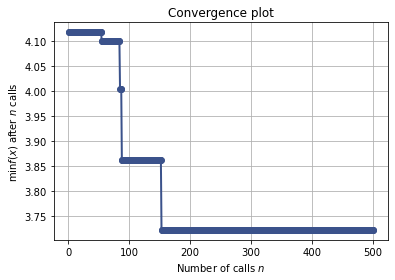

In [21]:
plot_convergence(search_result)
plt.savefig("convergence_plot.png")

ValueError: too many values to unpack (expected 2)

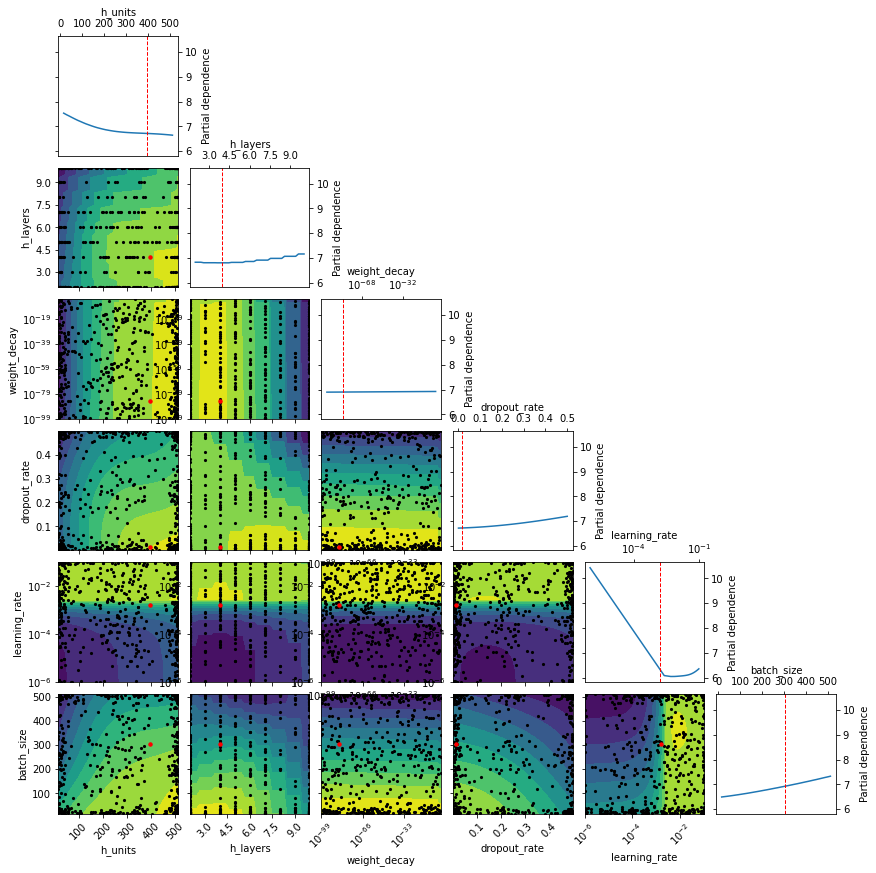

In [22]:
##List dim_names##
dim_names = ['h_units', 'h_layers', 'weight_decay', 'dropout_rate', 'learning_rate', 'batch_size']

##Plot objectives##
fig, ax = plot_objective(result = search_result, dimensions = dim_names)

ValueError: too many values to unpack (expected 2)

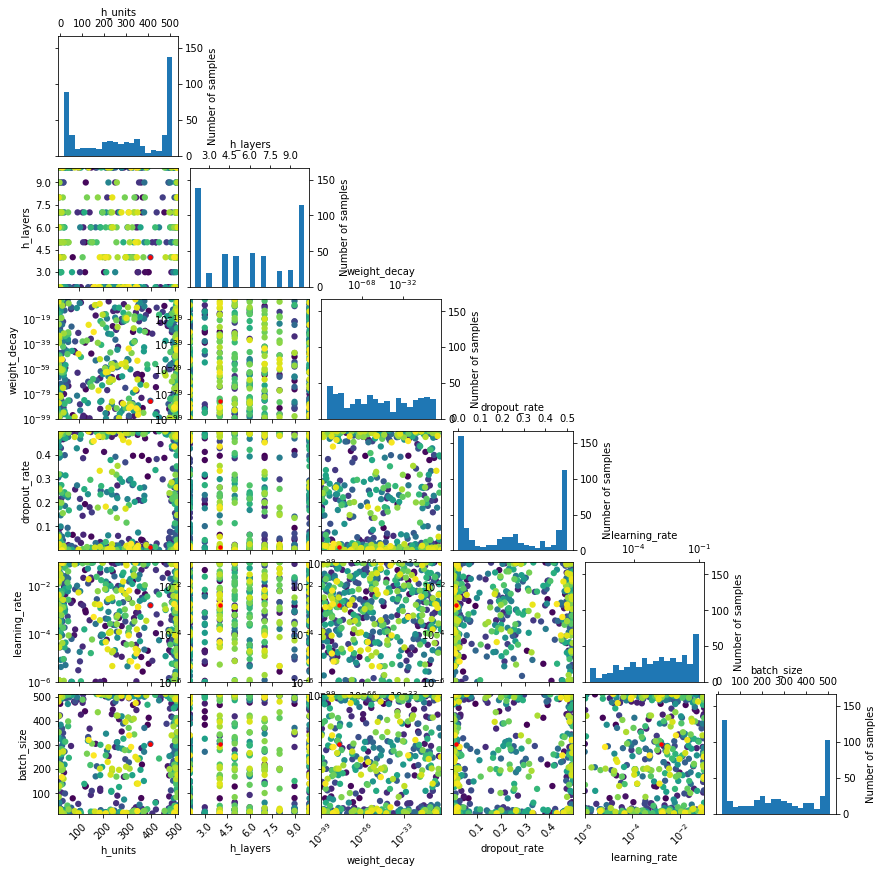

In [23]:
##Plot evaluations##
fig, ax = plot_evaluations(result = search_result, dimensions = dim_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 400)               0

INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_1\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

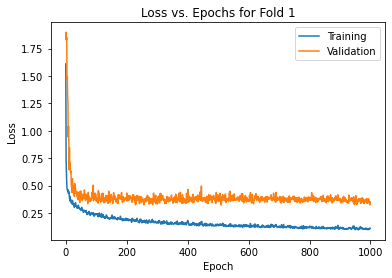

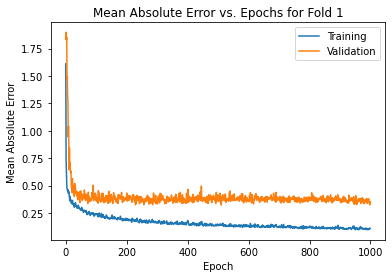

14/14 [==============================] - 0s 3ms/step - loss: 0.3507 - mean_absolute_error: 0.3507
Mean Absolute Error: 0.35070645809173584
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)         

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_2\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

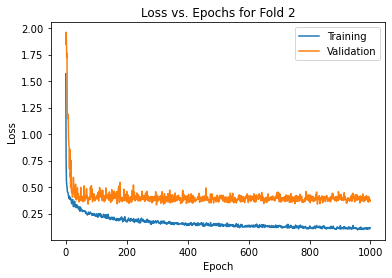

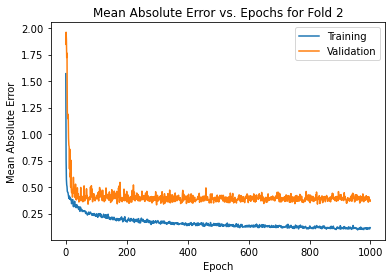

14/14 [==============================] - 0s 3ms/step - loss: 0.3450 - mean_absolute_error: 0.3450
Mean Absolute Error: 0.3449721038341522
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)          

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_3\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_b

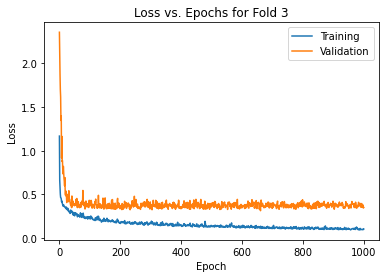

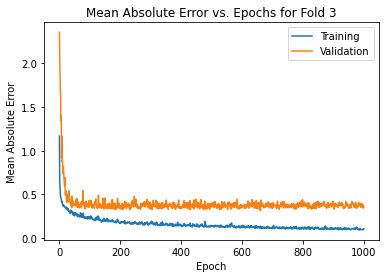

14/14 [==============================] - 0s 5ms/step - loss: 0.3573 - mean_absolute_error: 0.3573
Mean Absolute Error: 0.35730916261672974
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)         

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_b

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_4\assets


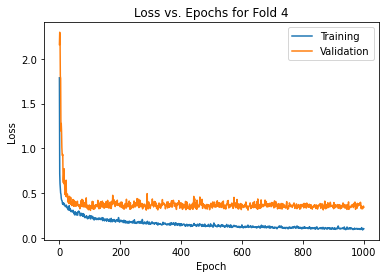

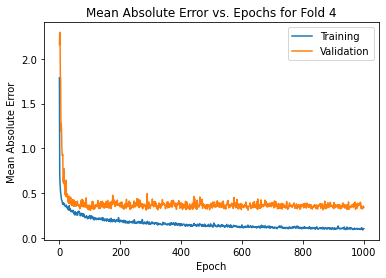

14/14 [==============================] - 0s 3ms/step - loss: 0.3397 - mean_absolute_error: 0.3397
Mean Absolute Error: 0.3396839499473572
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)          

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_5\assets


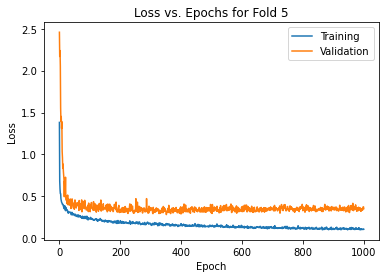

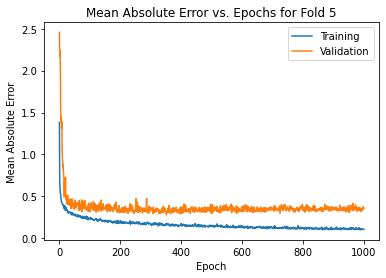

14/14 [==============================] - 0s 3ms/step - loss: 0.3504 - mean_absolute_error: 0.3504
Mean Absolute Error: 0.3503692150115967
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)          

INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_6\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

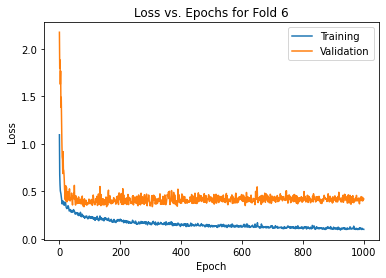

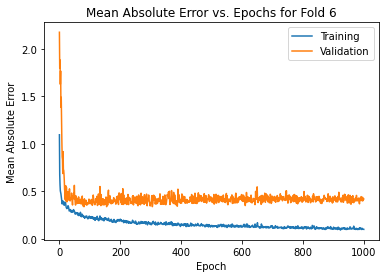

14/14 [==============================] - 0s 3ms/step - loss: 0.3747 - mean_absolute_error: 0.3747
Mean Absolute Error: 0.37471628189086914
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)         

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_7\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

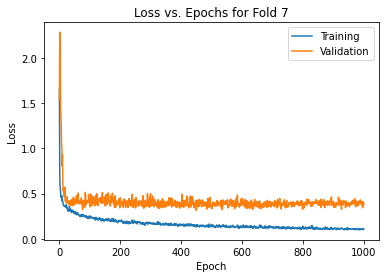

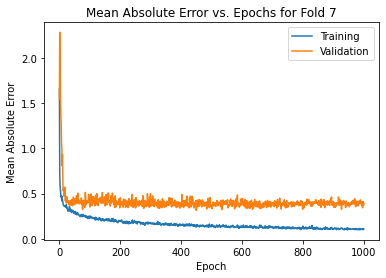

14/14 [==============================] - 0s 3ms/step - loss: 0.3214 - mean_absolute_error: 0.3214
Mean Absolute Error: 0.32138168811798096
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)         

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_b

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_8\assets


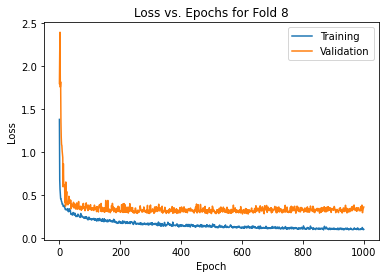

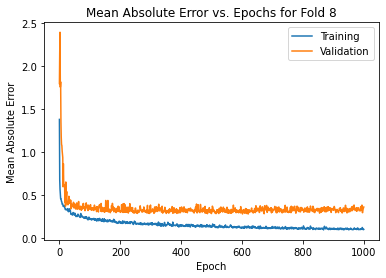

14/14 [==============================] - 0s 2ms/step - loss: 0.4177 - mean_absolute_error: 0.4177
Mean Absolute Error: 0.4176517426967621
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)          

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/val_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_9\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016

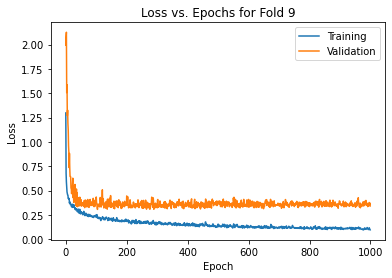

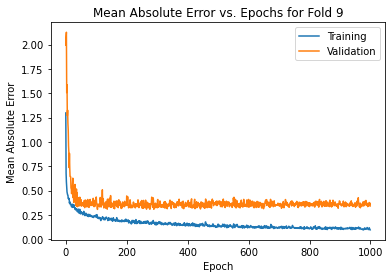

14/14 [==============================] - 0s 3ms/step - loss: 0.3442 - mean_absolute_error: 0.3442
Mean Absolute Error: 0.3442228138446808
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               45600     
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)          

INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_lr_0.0016_batch size_300_fold_10\assets
INFO:tensorflow:Assets written to: model_best/train_best/h_units_400_h_layers_4_wd_0_dr_0_

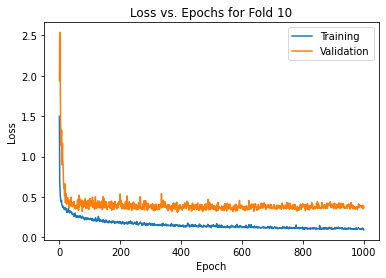

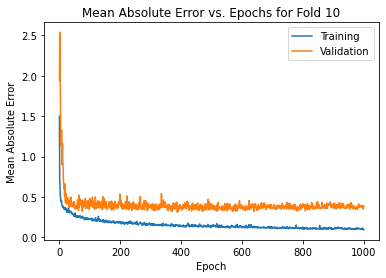

14/14 [==============================] - 0s 3ms/step - loss: 0.3803 - mean_absolute_error: 0.3803
Mean Absolute Error: 0.3803149461746216
[0.35070645809173584, 0.3449721038341522, 0.35730916261672974, 0.3396839499473572, 0.3503692150115967, 0.37471628189086914, 0.32138168811798096, 0.4176517426967621, 0.3442228138446808, 0.3803149461746216]


<Figure size 432x288 with 0 Axes>

In [39]:
mae = train_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300)
print(mae)

In [4]:
val_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'val', test_data = 'all')
print(val_mae)
print(sum(val_mae)/10)

14/14 [==============================] - 0s 3ms/step - loss: 0.3532 - mean_absolute_error: 0.3532
Mean Absolute Error for all: 0.3531532287597656
14/14 [==============================] - 0s 1ms/step - loss: 0.3458 - mean_absolute_error: 0.3458
Mean Absolute Error for all: 0.3458036184310913
14/14 [==============================] - 0s 1ms/step - loss: 0.3752 - mean_absolute_error: 0.3752
Mean Absolute Error for all: 0.3752345144748688
14/14 [==============================] - 0s 1ms/step - loss: 0.3681 - mean_absolute_error: 0.3681
Mean Absolute Error for all: 0.3680630624294281
14/14 [==============================] - 0s 1ms/step - loss: 0.3418 - mean_absolute_error: 0.3418
Mean Absolute Error for all: 0.3418198525905609
14/14 [==============================] - 0s 1ms/step - loss: 0.4187 - mean_absolute_error: 0.4187
Mean Absolute Error for all: 0.4187249541282654
14/14 [==============================] - 0s 1ms/step - loss: 0.3367 - mean_absolute_error: 0.3367
Mean Absolute Error for al

In [5]:
train_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'train', test_data = 'all')
print(train_mae)
print(sum(train_mae)/10)

14/14 [==============================] - 0s 1ms/step - loss: 0.3483 - mean_absolute_error: 0.3483
Mean Absolute Error for all: 0.34829992055892944
14/14 [==============================] - 0s 1ms/step - loss: 0.3350 - mean_absolute_error: 0.3350
Mean Absolute Error for all: 0.33504703640937805
14/14 [==============================] - 0s 1ms/step - loss: 0.3672 - mean_absolute_error: 0.3672
Mean Absolute Error for all: 0.3671751618385315
14/14 [==============================] - 0s 1ms/step - loss: 0.3449 - mean_absolute_error: 0.3449
Mean Absolute Error for all: 0.34493041038513184
14/14 [==============================] - 0s 1ms/step - loss: 0.3566 - mean_absolute_error: 0.3566
Mean Absolute Error for all: 0.3565726578235626
14/14 [==============================] - 0s 1ms/step - loss: 0.3733 - mean_absolute_error: 0.3733
Mean Absolute Error for all: 0.3733483850955963
14/14 [==============================] - 0s 1ms/step - loss: 0.3259 - mean_absolute_error: 0.3259
Mean Absolute Error for

In [6]:
all_fold_mae_val = np.zeros((10, 1))
for ion in working_ions:
    val_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'val', test_data = ion)
    avg_performance = sum(val_mae)/10
    print(f"Average val MAE for {ion} is {avg_performance}")
    for fold in range (1, 11, 1):
        all_fold_mae_val[fold-1] += val_mae[fold-1]
    print(val_mae)
    print(all_fold_mae_val)

5/5 [==============================] - 0s 1ms/step - loss: 0.1395 - mean_absolute_error: 0.1395
Mean Absolute Error for Al from Fold 1: 0.1395174115896225
5/5 [==============================] - 0s 1ms/step - loss: 0.1787 - mean_absolute_error: 0.1787
Mean Absolute Error for Al from Fold 2: 0.1786898970603943
5/5 [==============================] - 0s 1ms/step - loss: 0.1646 - mean_absolute_error: 0.1646
Mean Absolute Error for Al from Fold 3: 0.16463911533355713
5/5 [==============================] - 0s 1ms/step - loss: 0.1970 - mean_absolute_error: 0.1970
Mean Absolute Error for Al from Fold 4: 0.1969669908285141
5/5 [==============================] - 0s 998us/step - loss: 0.1734 - mean_absolute_error: 0.1734
Mean Absolute Error for Al from Fold 5: 0.17336873710155487
5/5 [==============================] - 0s 1ms/step - loss: 0.2613 - mean_absolute_error: 0.2613
Mean Absolute Error for Al from Fold 6: 0.261297345161438
5/5 [==============================] - 0s 1ms/step - loss: 0.1646 -

72/72 [==============================] - 0s 956us/step - loss: 0.2024 - mean_absolute_error: 0.2024
Mean Absolute Error for Li from Fold 3: 0.20238052308559418
72/72 [==============================] - 0s 983us/step - loss: 0.2228 - mean_absolute_error: 0.2228
Mean Absolute Error for Li from Fold 4: 0.22276155650615692
72/72 [==============================] - 0s 1ms/step - loss: 0.1578 - mean_absolute_error: 0.1578
Mean Absolute Error for Li from Fold 5: 0.1577702760696411
72/72 [==============================] - 0s 1ms/step - loss: 0.2250 - mean_absolute_error: 0.2250
Mean Absolute Error for Li from Fold 6: 0.22502127289772034
72/72 [==============================] - 0s 1ms/step - loss: 0.1554 - mean_absolute_error: 0.1554
Mean Absolute Error for Li from Fold 7: 0.15540005266666412
72/72 [==============================] - 0s 1ms/step - loss: 0.1399 - mean_absolute_error: 0.1399
Mean Absolute Error for Li from Fold 8: 0.1398775726556778
72/72 [==============================] - 0s 1ms/st

5/5 [==============================] - 0s 1ms/step - loss: 0.1135 - mean_absolute_error: 0.1135
Mean Absolute Error for Y from Fold 5: 0.11353275179862976
5/5 [==============================] - 0s 1ms/step - loss: 0.2092 - mean_absolute_error: 0.2092
Mean Absolute Error for Y from Fold 6: 0.20919685065746307
5/5 [==============================] - 0s 1ms/step - loss: 0.1380 - mean_absolute_error: 0.1380
Mean Absolute Error for Y from Fold 7: 0.1379839926958084
5/5 [==============================] - 0s 1ms/step - loss: 0.1058 - mean_absolute_error: 0.1058
Mean Absolute Error for Y from Fold 8: 0.10578178614377975
5/5 [==============================] - 0s 1ms/step - loss: 0.1537 - mean_absolute_error: 0.1537
Mean Absolute Error for Y from Fold 9: 0.15366221964359283
5/5 [==============================] - 0s 1ms/step - loss: 0.1563 - mean_absolute_error: 0.1563
Mean Absolute Error for Y from Fold 10: 0.15631268918514252
Average val MAE for Y is 0.14104223996400833
[0.12897761166095734, 0.1

In [7]:
all_fold_mae_train = np.zeros((10, 1))
for ion in working_ions:
    train_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'train', test_data = ion)
    avg_performance = sum(train_mae)/10
    print(f"Average train MAE for {ion} is {avg_performance}")
    for fold in range (1, 11, 1):
        all_fold_mae_train[fold-1] += train_mae[fold-1]
    print(train_mae)
    print(all_fold_mae_train)

5/5 [==============================] - 0s 1ms/step - loss: 0.0847 - mean_absolute_error: 0.0847
Mean Absolute Error for Al from Fold 1: 0.08465280383825302
5/5 [==============================] - 0s 1ms/step - loss: 0.1189 - mean_absolute_error: 0.1189
Mean Absolute Error for Al from Fold 2: 0.11887142062187195
5/5 [==============================] - 0s 1ms/step - loss: 0.0900 - mean_absolute_error: 0.0900
Mean Absolute Error for Al from Fold 3: 0.0899851843714714
5/5 [==============================] - 0s 1ms/step - loss: 0.1316 - mean_absolute_error: 0.1316
Mean Absolute Error for Al from Fold 4: 0.13161873817443848
5/5 [==============================] - 0s 1ms/step - loss: 0.1314 - mean_absolute_error: 0.1314
Mean Absolute Error for Al from Fold 5: 0.13141128420829773
5/5 [==============================] - 0s 2ms/step - loss: 0.1165 - mean_absolute_error: 0.1165
Mean Absolute Error for Al from Fold 6: 0.11653859168291092
5/5 [==============================] - 0s 1ms/step - loss: 0.0894

72/72 [==============================] - 0s 1ms/step - loss: 0.1332 - mean_absolute_error: 0.1332
Mean Absolute Error for Li from Fold 3: 0.1331823766231537
72/72 [==============================] - 0s 1ms/step - loss: 0.1094 - mean_absolute_error: 0.1094
Mean Absolute Error for Li from Fold 4: 0.10935048013925552
72/72 [==============================] - 0s 1ms/step - loss: 0.1190 - mean_absolute_error: 0.1190
Mean Absolute Error for Li from Fold 5: 0.11898940801620483
72/72 [==============================] - 0s 1ms/step - loss: 0.1345 - mean_absolute_error: 0.1345
Mean Absolute Error for Li from Fold 6: 0.1344633400440216
72/72 [==============================] - 0s 1ms/step - loss: 0.1195 - mean_absolute_error: 0.1195
Mean Absolute Error for Li from Fold 7: 0.11949388682842255
72/72 [==============================] - 0s 1ms/step - loss: 0.1194 - mean_absolute_error: 0.1194
Mean Absolute Error for Li from Fold 8: 0.11935967206954956
72/72 [==============================] - 0s 1ms/step -

5/5 [==============================] - 0s 1ms/step - loss: 0.1022 - mean_absolute_error: 0.1022
Mean Absolute Error for Y from Fold 5: 0.10222382843494415
5/5 [==============================] - 0s 1ms/step - loss: 0.0813 - mean_absolute_error: 0.0813
Mean Absolute Error for Y from Fold 6: 0.0812670961022377
5/5 [==============================] - 0s 1ms/step - loss: 0.0899 - mean_absolute_error: 0.0899
Mean Absolute Error for Y from Fold 7: 0.08986570686101913
5/5 [==============================] - 0s 1ms/step - loss: 0.0815 - mean_absolute_error: 0.0815
Mean Absolute Error for Y from Fold 8: 0.0814705640077591
5/5 [==============================] - 0s 2ms/step - loss: 0.0902 - mean_absolute_error: 0.0902
Mean Absolute Error for Y from Fold 9: 0.09018589556217194
5/5 [==============================] - 0s 2ms/step - loss: 0.1061 - mean_absolute_error: 0.1061
Mean Absolute Error for Y from Fold 10: 0.10613024979829788
Average train MAE for Y is 0.08584097735583782
[0.06794865429401398, 0.

In [8]:
get_predictions(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'train')

Predictions from Fold 1: [[2.9223862]
 [3.0997398]
 [1.2139773]
 [3.0471866]
 [3.9789357]
 [4.0644274]
 [3.1429157]
 [4.2592063]
 [3.876596 ]
 [3.1589942]
 [3.1496892]
 [1.4843844]
 [0.8322872]
 [3.4290853]]
Predictions from Fold 2: [[3.1153846]
 [3.5093827]
 [1.0895367]
 [3.7523348]
 [3.9970837]
 [4.246398 ]
 [3.2232666]
 [4.2158484]
 [4.7052803]
 [4.2553225]
 [3.6395922]
 [1.5452707]
 [1.0167611]
 [3.83421  ]]
Predictions from Fold 3: [[3.3250973 ]
 [3.7750595 ]
 [1.5057949 ]
 [3.7106044 ]
 [4.3945765 ]
 [4.283314  ]
 [3.6824653 ]
 [4.2471156 ]
 [4.3580265 ]
 [3.5719128 ]
 [3.6931326 ]
 [1.6368773 ]
 [0.88048166]
 [3.380002  ]]
Predictions from Fold 4: [[2.9544027 ]
 [3.0119207 ]
 [1.0345223 ]
 [2.8825088 ]
 [3.7143571 ]
 [4.174502  ]
 [3.5139606 ]
 [4.249118  ]
 [4.578356  ]
 [3.4525332 ]
 [3.5857255 ]
 [1.4372213 ]
 [0.91807336]
 [4.0557837 ]]
Predictions from Fold 5: [[3.1420548]
 [3.6981096]
 [1.9882151]
 [3.2965086]
 [4.006166 ]
 [4.2659774]
 [3.3920796]
 [4.3185925]
 [4.3192453

In [9]:
val_expt_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'val', test_data = 'expt')
print(val_expt_mae)
print(sum(val_expt_mae)/10)

1/1 [==============================] - 0s 996us/step - loss: 0.5151 - mean_absolute_error: 0.5151
Mean Absolute Error for experimental electrodes from Fold 1: 0.5151239633560181
1/1 [==============================] - 0s 2ms/step - loss: 0.6401 - mean_absolute_error: 0.6401
Mean Absolute Error for experimental electrodes from Fold 2: 0.6401097178459167
1/1 [==============================] - 0s 998us/step - loss: 0.6173 - mean_absolute_error: 0.6173
Mean Absolute Error for experimental electrodes from Fold 3: 0.6172828674316406
1/1 [==============================] - 0s 998us/step - loss: 0.5637 - mean_absolute_error: 0.5637
Mean Absolute Error for experimental electrodes from Fold 4: 0.5636749267578125
1/1 [==============================] - 0s 996us/step - loss: 0.6581 - mean_absolute_error: 0.6581
Mean Absolute Error for experimental electrodes from Fold 5: 0.6581096649169922
1/1 [==============================] - 0s 999us/step - loss: 0.4894 - mean_absolute_error: 0.4894
Mean Absolute 

In [10]:
train_expt_mae = evaluate_best_model(h_units = 400, h_layers = 4, weight_decay = 0, dropout_rate = 0, learning_rate = 0.0016, batch_size = 300, model_type = 'train', test_data = 'expt')
print(train_expt_mae)
print(sum(train_expt_mae)/10)

1/1 [==============================] - 0s 997us/step - loss: 0.4192 - mean_absolute_error: 0.4192
Mean Absolute Error for experimental electrodes from Fold 1: 0.41924360394477844
1/1 [==============================] - 0s 997us/step - loss: 0.7285 - mean_absolute_error: 0.7285
Mean Absolute Error for experimental electrodes from Fold 2: 0.7284935712814331
1/1 [==============================] - 0s 998us/step - loss: 0.6960 - mean_absolute_error: 0.6960
Mean Absolute Error for experimental electrodes from Fold 3: 0.6959641575813293
1/1 [==============================] - 0s 998us/step - loss: 0.6231 - mean_absolute_error: 0.6231
Mean Absolute Error for experimental electrodes from Fold 4: 0.6231473088264465
1/1 [==============================] - 0s 1ms/step - loss: 0.6451 - mean_absolute_error: 0.6451
Mean Absolute Error for experimental electrodes from Fold 5: 0.645084798336029
1/1 [==============================] - 0s 998us/step - loss: 0.5341 - mean_absolute_error: 0.5341
Mean Absolute 

In [11]:
dill.dump_session('notebook_env.db')

In [2]:
dill.load_session('notebook_env.db')

In [3]:
tf.keras.backend.clear_session()